In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.optimizers import Adam
import exifread
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K

In [2]:
quant = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 48, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]], 'uint8')

In [3]:
def add_padding(image, block_size):
    
    h, w = image.shape[:2]

    if h % block_size != 0:
        rem = h % block_size
        extra = block_size - rem
        image = cv2.copyMakeBorder(image, 0, extra, 0, 0, cv2.BORDER_CONSTANT, value=0)

    if w % block_size != 0:
        rem = w % block_size
        extra = block_size - rem
        image = cv2.copyMakeBorder(image, 0, 0, 0, extra, cv2.BORDER_CONSTANT, value=0)

    return image

In [4]:
def zig_zag_encoder(code_blocks_list, num_comp, block_size):

    num_blocks = len(code_blocks_list)
    
    final_code = []
        
    for l in range(num_blocks):   
        i = j = 0
        flag = True
        codes = []
        last_nonzero_comp = -1
        for k in range(num_comp):
            
            comp = np.round(code_blocks_list[l][i][j])
            
            codes.append(comp)            
            
            num_non_zeros = np.count_nonzero(comp)
            
            if num_non_zeros >= 1:                
                last_nonzero_comp = k
            
            if flag == True:
                
                next_i = i - 1
                next_j = j + 1
                
                if next_i < 0 or next_j >= block_size:
                    if next_j >= block_size:
                        flag = False
                        i += 1
                        continue
                    else:
                        flag = False
                        j += 1
                        continue
                else:
                    i -= 1
                    j += 1
                    
            if flag == False:

                next_i = i + 1
                next_j = j - 1

                if next_j < 0 or next_i >= block_size:
                    if next_i >= block_size:
                        flag = True
                        j += 1
                        continue
                    else:
                        flag = True
                        i += 1
                        continue
                else:
                    i += 1
                    j -= 1
                        
        final_code.append(codes)
        
    return final_code

In [5]:
def get_features(image_path):
    image = cv2.imread(image_path)
    im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm_img = image - 128
    block_size = 8
    h, w = im_gray.shape
    all_freq = []
    im_gray = add_padding(im_gray, block_size)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = im_gray[i:i+block_size, j:j+block_size]
            dct_block = cv2.dct(np.float64(block))
            quatized = dct_block / quant
            rounded = np.round(quatized)
            dequantized = rounded * quant
            comp_64 = zig_zag_encoder([dequantized], 64, block_size)
            ac_63 = np.delete(comp_64, 0)
            all_freq.append(ac_63)
    all_freq_np_arr = np.array(all_freq)
    features = []
    for i in range(63):
        histogram, _ = np.histogram(all_freq_np_arr[:,i], bins=41, range=(-20, 20), density=True)
        features.extend(histogram)
    
    return features

In [6]:
# dataset_path = './SHADE/'

# labels = ['ANDROID', 'APP-MAC', 'APP-WIN', 'IPHONE', 'ORIGINAL', 'WEB-IPAD', 'WEB-MAC', 'WEB-WIN']
# QF = ['QF-50', 'QF-60', 'QF-70', 'QF-80', 'QF-90', 'QF-100']

# X_whole = []
# y_whole = []

# for qf in QF:
#     for label in labels:
#         label_path = os.path.join(dataset_path, label + '/' + qf)
#         for filename in os.listdir(label_path):
#             if filename != '.DS_Store':
#                 filepath = os.path.join(label_path, filename)
#                 feature_vector = get_features(filepath)
#                 X_whole.append(feature_vector)
#                 y_whole.append(label)

In [7]:
# np.savetxt('features_all.txt', X_whole, fmt='%s')
# np.savetxt('labels_all.txt', y_whole, fmt='%s')

In [8]:
def read_features_from_txt(file_path):
    my_list = []
    with open(file_path, 'r') as f:
        for line in f:
            sublist = line.strip().split()
            my_list.append(sublist)

    my_list = np.array(my_list, dtype=np.float64)
    
    return my_list

def read_labels_from_txt(file_path):
    my_list = []
    with open(file_path, 'r') as f:
        for line in f:
            sublist = line.strip().split()
            my_list.append(sublist)
    
    return my_list

In [9]:
def normalize(X):
    for i in range(X.shape[0]):
        for j in range(0, X.shape[1], 41):
            sublist = X[i][j:j+41]
            X[i][j:j+41] = (sublist - np.min(sublist)) / (np.max(sublist) - np.min(sublist))
            
    return X

In [26]:
X9 = read_features_from_txt('features.txt')
y9 = read_labels_from_txt('labels.txt')

X_all = read_features_from_txt('features_all.txt')
y_all = read_labels_from_txt('labels_all.txt')

X9 = normalize(X9)
X_all = normalize(X_all)

In [19]:
import struct

def get_quantization_tables(image_file):
    with open(image_file, "rb") as f:
        f.seek(0x0100)
        tables = []
        for i in range(2):
            table = struct.unpack("64B", f.read(64))
            tables.append(table)

    return tables

def get_huffman_encoding_tables(image_file):
  
    with open(image_file, "rb") as f:
        f.seek(0x01C0)
        tables = []
        for i in range(2):
            table = struct.unpack("16B", f.read(16))
            tables.append(table)

    return tables

def get_component_information(image_file):
    with open(image_file, "rb") as f:
        f.seek(0x0200)
        components = []
        for i in range(3):
            features = struct.unpack("6B", f.read(6))
            components.append(features)

    return components

def get_optimized_coding_and_progressive_mode(image_file):
    with open(image_file, "rb") as f:
        f.seek(0x020E)
        flags = struct.unpack("BB", f.read(2))

    return flags

def get_image_size(image_file):
    
    with open(image_file, "rb") as f:
        f.seek(0x0210)
        size = struct.unpack("HH", f.read(2))

    return size

In [22]:
dataset_path = './SHADE/'

labels = ['ANDROID', 'APP-MAC', 'APP-WIN', 'IPHONE', 'ORIGINAL', 'WEB-IPAD', 'WEB-MAC', 'WEB-WIN']

QF = ['QF-50', 'QF-60', 'QF-70', 'QF-80', 'QF-90', 'QF-100']

i = 0

X_9 = np.zeros((X9.shape[0], 551))

for qf in QF:
    for label in labels:
        label_path = os.path.join(dataset_path, label + '/' + qf)
        for filename in os.listdir(label_path):
            if filename != '.DS_Store':
                filepath = os.path.join(label_path, filename)
                quant_table = get_quantization_tables(filepath)
                huff_table = get_huffman_encoding_tables(filepath)
                comp_info = get_component_information(filepath)
                flags = get_optimized_coding_and_progressive_mode(filepath)
                h,w = cv2.imread(filepath).shape[:2]
                temp = np.hstack([X9[i], np.array(quant_table[0])])
                temp = np.hstack([temp, np.array(quant_table[1])])
                temp = np.hstack([temp, np.array(huff_table[0])])
                temp = np.hstack([temp, np.array(huff_table[1])])
                temp = np.hstack([temp, np.array(comp_info[0])])
                temp = np.hstack([temp, np.array(comp_info[1])])
                temp = np.hstack([temp, np.array(comp_info[2])])
                temp = np.hstack([temp, np.array(flags)])
                X_9[i] = np.hstack([temp, np.array([h,w])])
                i+=1

In [29]:
dataset_path = './SHADE/'

labels = ['ANDROID', 'APP-MAC', 'APP-WIN', 'IPHONE', 'ORIGINAL', 'WEB-IPAD', 'WEB-MAC', 'WEB-WIN']

QF = ['QF-50', 'QF-60', 'QF-70', 'QF-80', 'QF-90', 'QF-100']

i = 0

Xall = np.zeros((X_all.shape[0], 2765))

for qf in QF:
    for label in labels:
        label_path = os.path.join(dataset_path, label + '/' + qf)
        for filename in os.listdir(label_path):
            if filename != '.DS_Store':
                filepath = os.path.join(label_path, filename)
                quant_table = get_quantization_tables(filepath)
                huff_table = get_huffman_encoding_tables(filepath)
                comp_info = get_component_information(filepath)
                flags = get_optimized_coding_and_progressive_mode(filepath)
                h,w = cv2.imread(filepath).shape[:2]
                temp = np.hstack([X_all[i], np.array(quant_table[0])])
                temp = np.hstack([temp, np.array(quant_table[1])])
                temp = np.hstack([temp, np.array(huff_table[0])])
                temp = np.hstack([temp, np.array(huff_table[1])])
                temp = np.hstack([temp, np.array(comp_info[0])])
                temp = np.hstack([temp, np.array(comp_info[1])])
                temp = np.hstack([temp, np.array(comp_info[2])])
                temp = np.hstack([temp, np.array(flags)])
                Xall[i] = np.hstack([temp, np.array([h,w])])
                i+=1

### SVM with 9 AC Components

In [30]:
X = np.array(X_9)
y = np.array(y9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm = SVC(kernel='rbf', gamma=0.1)

svm.fit(X_train, y_train)

acc = svm.score(X_test, y_test)
print('Accuracy:', acc)

/Users/mohitkumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.41597222222222224


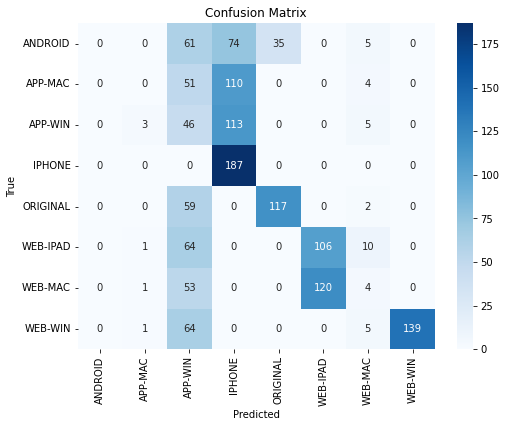

In [31]:
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM with all AC components

In [32]:
X = np.array(Xall)
y = np.array(y_all)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm = SVC(kernel='rbf', gamma=0.1)

svm.fit(X_train, y_train)

acc = svm.score(X_test, y_test)
print('Accuracy:', acc)

/Users/mohitkumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.3951388888888889


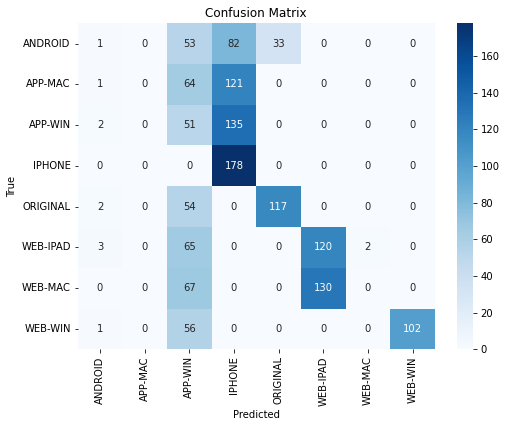

In [33]:
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MLP with 9 AC Components

In [34]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y9)

X_train, X_test, y_train, y_test = train_test_split(X_9, encoded_labels, test_size=0.2)

num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_encoded, epochs=500, batch_size=128, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Accuracy:', accuracy)

/Users/mohitkumar/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/500


2023-05-15 01:36:28.325658: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/45 [==============================] - 1s 2ms/step - loss: 3.5024 - accuracy: 0.3325
Epoch 2/500
45/45 [==============================] - 0s 2ms/step - loss: 1.6120 - accuracy: 0.4267
Epoch 3/500
45/45 [==============================] - 0s 3ms/step - loss: 1.2654 - accuracy: 0.4821
Epoch 4/500
45/45 [==============================] - 0s 3ms/step - loss: 1.1673 - accuracy: 0.5042
Epoch 5/500
45/45 [==============================] - 0s 3ms/step - loss: 1.0752 - accuracy: 0.5250
Epoch 6/500
45/45 [==============================] - 0s 3ms/step - loss: 1.0350 - accuracy: 0.5247
Epoch 7/500
45/45 [==============================] - 0s 3ms/step - loss: 0.9935 - accuracy: 0.5424
Epoch 8/500
45/45 [==============================] - 0s 3ms/step - loss: 0.9846 - accuracy: 0.5476
Epoch 9/500
45/45 [==============================] - 0s 3ms/step - loss: 0.9475 - accuracy: 0.5587
Epoch 10/500
45/45 [==============================] - 0s 3ms/step - loss: 0.9525 - accuracy: 0.5587
Epoch 11/500
45/45 [=

45/45 [==============================] - 0s 4ms/step - loss: 0.7571 - accuracy: 0.6318
Epoch 84/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7568 - accuracy: 0.6363
Epoch 85/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7515 - accuracy: 0.6375
Epoch 86/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7476 - accuracy: 0.6342
Epoch 87/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7532 - accuracy: 0.6358
Epoch 88/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7532 - accuracy: 0.6340
Epoch 89/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7475 - accuracy: 0.6361
Epoch 90/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7480 - accuracy: 0.6352
Epoch 91/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7526 - accuracy: 0.6345
Epoch 92/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7523 - accuracy: 0.6368
Epoch 93/500


45/45 [==============================] - 0s 3ms/step - loss: 0.7388 - accuracy: 0.6415
Epoch 165/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7399 - accuracy: 0.6446
Epoch 166/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7423 - accuracy: 0.6378
Epoch 167/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7455 - accuracy: 0.6332
Epoch 168/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7381 - accuracy: 0.6406
Epoch 169/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7423 - accuracy: 0.6342
Epoch 170/500
45/45 [==============================] - 0s 4ms/step - loss: 0.7407 - accuracy: 0.6399
Epoch 171/500
45/45 [==============================] - 0s 4ms/step - loss: 0.7380 - accuracy: 0.6345
Epoch 172/500
45/45 [==============================] - 0s 4ms/step - loss: 0.7371 - accuracy: 0.6450
Epoch 173/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7369 - accuracy: 0.6403
Epoc

45/45 [==============================] - 0s 3ms/step - loss: 0.7362 - accuracy: 0.6422
Epoch 246/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7362 - accuracy: 0.6328
Epoch 247/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7369 - accuracy: 0.6380
Epoch 248/500
45/45 [==============================] - 0s 4ms/step - loss: 0.7357 - accuracy: 0.6472
Epoch 249/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7380 - accuracy: 0.6384
Epoch 250/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7371 - accuracy: 0.6342
Epoch 251/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7370 - accuracy: 0.6361
Epoch 252/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7363 - accuracy: 0.6408
Epoch 253/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7361 - accuracy: 0.6363
Epoch 254/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.6403
Epoc

45/45 [==============================] - 0s 4ms/step - loss: 0.7357 - accuracy: 0.6389
Epoch 327/500
45/45 [==============================] - 0s 4ms/step - loss: 0.7364 - accuracy: 0.6391
Epoch 328/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7363 - accuracy: 0.6344
Epoch 329/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7352 - accuracy: 0.6420
Epoch 330/500
45/45 [==============================] - 0s 4ms/step - loss: 0.7369 - accuracy: 0.6363
Epoch 331/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.6401
Epoch 332/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7343 - accuracy: 0.6311
Epoch 333/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7358 - accuracy: 0.6448
Epoch 334/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7339 - accuracy: 0.6425
Epoch 335/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7354 - accuracy: 0.6394
Epoc

45/45 [==============================] - 0s 3ms/step - loss: 0.7351 - accuracy: 0.6415
Epoch 408/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.6340
Epoch 409/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7352 - accuracy: 0.6373
Epoch 410/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7343 - accuracy: 0.6399
Epoch 411/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7350 - accuracy: 0.6417
Epoch 412/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7355 - accuracy: 0.6323
Epoch 413/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7336 - accuracy: 0.6392
Epoch 414/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7334 - accuracy: 0.6415
Epoch 415/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.6311
Epoch 416/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7333 - accuracy: 0.6427
Epoc

45/45 [==============================] - 0s 3ms/step - loss: 0.7331 - accuracy: 0.6410
Epoch 489/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7328 - accuracy: 0.6375
Epoch 490/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.6418
Epoch 491/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7345 - accuracy: 0.6415
Epoch 492/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.6391
Epoch 493/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7335 - accuracy: 0.6391
Epoch 494/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7342 - accuracy: 0.6394
Epoch 495/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7339 - accuracy: 0.6405
Epoch 496/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7327 - accuracy: 0.6339
Epoch 497/500
45/45 [==============================] - 0s 3ms/step - loss: 0.7337 - accuracy: 0.6358
Epoc

45/45 [==============================] - 0s 631us/step


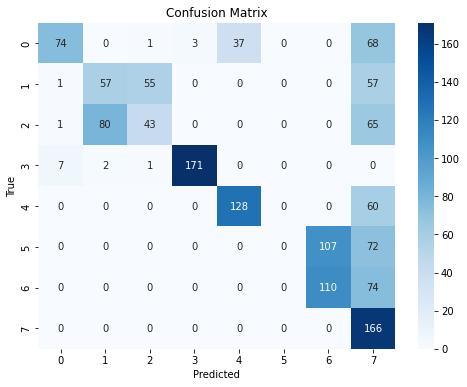

In [35]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MLP with all AC Components

In [37]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_all)

X_train, X_test, y_train, y_test = train_test_split(Xall, encoded_labels, test_size=0.2)

num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_encoded, epochs=500, batch_size=128, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Accuracy:', accuracy)

Epoch 1/500
45/45 [==============================] - 1s 5ms/step - loss: 3.1753 - accuracy: 0.3297
Epoch 2/500
45/45 [==============================] - 0s 6ms/step - loss: 1.2055 - accuracy: 0.4736
Epoch 3/500
45/45 [==============================] - 0s 11ms/step - loss: 1.0879 - accuracy: 0.4967
Epoch 4/500
45/45 [==============================] - 0s 10ms/step - loss: 1.0259 - accuracy: 0.5177
Epoch 5/500
45/45 [==============================] - 0s 8ms/step - loss: 0.9967 - accuracy: 0.5259
Epoch 6/500
45/45 [==============================] - 0s 8ms/step - loss: 0.9677 - accuracy: 0.5420
Epoch 7/500
45/45 [==============================] - 0s 8ms/step - loss: 0.9455 - accuracy: 0.5422
Epoch 8/500
45/45 [==============================] - 0s 8ms/step - loss: 0.9307 - accuracy: 0.5562
Epoch 9/500
45/45 [==============================] - 0s 9ms/step - loss: 0.9121 - accuracy: 0.5691
Epoch 10/500
45/45 [==============================] - 0s 8ms/step - loss: 0.9167 - accuracy: 0.5668
Epoch 1

45/45 [==============================] - 0s 8ms/step - loss: 0.7618 - accuracy: 0.6345
Epoch 83/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7531 - accuracy: 0.6349
Epoch 84/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7553 - accuracy: 0.6306
Epoch 85/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7515 - accuracy: 0.6359
Epoch 86/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7491 - accuracy: 0.6352
Epoch 87/500
45/45 [==============================] - 0s 10ms/step - loss: 0.7519 - accuracy: 0.6340
Epoch 88/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7503 - accuracy: 0.6375
Epoch 89/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7518 - accuracy: 0.6306
Epoch 90/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7514 - accuracy: 0.6352
Epoch 91/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7544 - accuracy: 0.6354
Epoch 92/500

45/45 [==============================] - 1s 11ms/step - loss: 0.7453 - accuracy: 0.6366
Epoch 164/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7453 - accuracy: 0.6389
Epoch 165/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7474 - accuracy: 0.6394
Epoch 166/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7473 - accuracy: 0.6328
Epoch 167/500
45/45 [==============================] - 0s 10ms/step - loss: 0.7561 - accuracy: 0.6363
Epoch 168/500
45/45 [==============================] - 0s 9ms/step - loss: 0.7895 - accuracy: 0.6276
Epoch 169/500
45/45 [==============================] - 0s 8ms/step - loss: 0.8064 - accuracy: 0.6115
Epoch 170/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7780 - accuracy: 0.6278
Epoch 171/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7553 - accuracy: 0.6335
Epoch 172/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7454 - accuracy: 0.6370
Ep

45/45 [==============================] - 0s 7ms/step - loss: 0.7433 - accuracy: 0.6328
Epoch 245/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7476 - accuracy: 0.6333
Epoch 246/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7456 - accuracy: 0.6318
Epoch 247/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7432 - accuracy: 0.6377
Epoch 248/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7425 - accuracy: 0.6396
Epoch 249/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7431 - accuracy: 0.6384
Epoch 250/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7498 - accuracy: 0.6345
Epoch 251/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7694 - accuracy: 0.6253
Epoch 252/500
45/45 [==============================] - 0s 8ms/step - loss: 0.8057 - accuracy: 0.6236
Epoch 253/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7826 - accuracy: 0.6253
Epoc

45/45 [==============================] - 0s 7ms/step - loss: 0.7416 - accuracy: 0.6330
Epoch 326/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7412 - accuracy: 0.6366
Epoch 327/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7418 - accuracy: 0.6368
Epoch 328/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7427 - accuracy: 0.6401
Epoch 329/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7412 - accuracy: 0.6424
Epoch 330/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7459 - accuracy: 0.6359
Epoch 331/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7470 - accuracy: 0.6286
Epoch 332/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7442 - accuracy: 0.6366
Epoch 333/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7443 - accuracy: 0.6415
Epoch 334/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7435 - accuracy: 0.6361
Epoc

45/45 [==============================] - 0s 9ms/step - loss: 0.7413 - accuracy: 0.6351
Epoch 407/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7410 - accuracy: 0.6344
Epoch 408/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7417 - accuracy: 0.6380
Epoch 409/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7449 - accuracy: 0.6352
Epoch 410/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7418 - accuracy: 0.6352
Epoch 411/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7413 - accuracy: 0.6345
Epoch 412/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7413 - accuracy: 0.6356
Epoch 413/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7408 - accuracy: 0.6339
Epoch 414/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7409 - accuracy: 0.6380
Epoch 415/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7404 - accuracy: 0.6347
Epoc

45/45 [==============================] - 0s 9ms/step - loss: 0.7412 - accuracy: 0.6332
Epoch 488/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7412 - accuracy: 0.6368
Epoch 489/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7411 - accuracy: 0.6358
Epoch 490/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7410 - accuracy: 0.6347
Epoch 491/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7417 - accuracy: 0.6347
Epoch 492/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7419 - accuracy: 0.6382
Epoch 493/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7426 - accuracy: 0.6361
Epoch 494/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7544 - accuracy: 0.6276
Epoch 495/500
45/45 [==============================] - 0s 8ms/step - loss: 0.7734 - accuracy: 0.6274
Epoch 496/500
45/45 [==============================] - 0s 7ms/step - loss: 0.7849 - accuracy: 0.6219
Epoc

45/45 [==============================] - 0s 896us/step


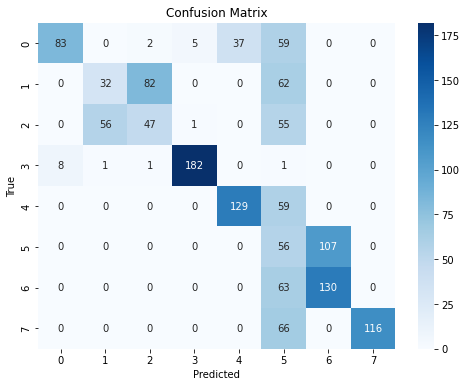

In [38]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### P-CNN with 9 AC Components

In [39]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y9)

X_train, X_test, y_train, y_test = train_test_split(X_9, encoded_labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=8)
y_test_encoded = to_categorical(y_test, num_classes=8)
y_valid_encoded = to_categorical(y_valid, num_classes=8)

X_train = np.array(X_train)
y_train_encoded = np.array(y_train_encoded)
X_valid = np.array(X_valid)
y_valid_encoded = np.array(y_valid_encoded)

def statistical_moments(x):
    min_val = K.min(x, axis=1, keepdims=True)
    max_val = K.max(x, axis=1, keepdims=True)
    mean_val = K.mean(x, axis=1, keepdims=True)
    return K.concatenate([min_val, max_val, mean_val], axis=1)

cnn = tf.keras.Sequential()
cnn.add(layers.Conv1D(8, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Conv1D(16, kernel_size=5, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Conv1D(32, kernel_size=5, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Lambda(statistical_moments))  # Add the statistical moments layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(8, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

cnn.fit(X_train, y_train_encoded, batch_size=128, epochs=500, validation_data=(X_valid, y_valid_encoded))

loss, accuracy = cnn.evaluate(X_test, y_test_encoded)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/500


/Users/mohitkumar/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


36/36 [==============================] - 1s 14ms/step - loss: 12.5030 - accuracy: 0.1053 - val_loss: 4.5024 - val_accuracy: 0.1085
Epoch 2/500
36/36 [==============================] - 1s 16ms/step - loss: 3.3065 - accuracy: 0.2068 - val_loss: 2.4326 - val_accuracy: 0.2786
Epoch 3/500
36/36 [==============================] - 1s 22ms/step - loss: 2.1653 - accuracy: 0.2507 - val_loss: 1.7734 - val_accuracy: 0.2734
Epoch 4/500
36/36 [==============================] - 1s 20ms/step - loss: 1.6071 - accuracy: 0.3987 - val_loss: 1.4904 - val_accuracy: 0.4566
Epoch 5/500
36/36 [==============================] - 1s 23ms/step - loss: 1.4197 - accuracy: 0.4603 - val_loss: 1.3787 - val_accuracy: 0.4809
Epoch 6/500
36/36 [==============================] - 1s 21ms/step - loss: 1.3273 - accuracy: 0.4694 - val_loss: 1.3157 - val_accuracy: 0.4852
Epoch 7/500
36/36 [==============================] - 1s 21ms/step - loss: 1.2802 - accuracy: 0.4768 - val_loss: 1.2805 - val_accuracy: 0.4818
Epoch 8/500
36/36

36/36 [==============================] - 1s 20ms/step - loss: 1.0796 - accuracy: 0.5234 - val_loss: 1.1329 - val_accuracy: 0.5087
Epoch 59/500
36/36 [==============================] - 1s 21ms/step - loss: 1.0862 - accuracy: 0.5115 - val_loss: 1.1232 - val_accuracy: 0.5104
Epoch 60/500
36/36 [==============================] - 1s 18ms/step - loss: 1.0829 - accuracy: 0.5189 - val_loss: 1.1077 - val_accuracy: 0.5069
Epoch 61/500
36/36 [==============================] - 1s 19ms/step - loss: 1.0765 - accuracy: 0.5260 - val_loss: 1.1130 - val_accuracy: 0.5156
Epoch 62/500
36/36 [==============================] - 1s 18ms/step - loss: 1.0746 - accuracy: 0.5312 - val_loss: 1.1103 - val_accuracy: 0.4983
Epoch 63/500
36/36 [==============================] - 1s 18ms/step - loss: 1.0792 - accuracy: 0.5217 - val_loss: 1.1181 - val_accuracy: 0.5000
Epoch 64/500
36/36 [==============================] - 1s 18ms/step - loss: 1.0787 - accuracy: 0.5234 - val_loss: 1.1163 - val_accuracy: 0.5095
Epoch 65/500

36/36 [==============================] - 1s 20ms/step - loss: 1.0476 - accuracy: 0.5441 - val_loss: 1.1154 - val_accuracy: 0.5009
Epoch 116/500
36/36 [==============================] - 1s 20ms/step - loss: 1.0476 - accuracy: 0.5477 - val_loss: 1.1084 - val_accuracy: 0.5061
Epoch 117/500
36/36 [==============================] - 1s 22ms/step - loss: 1.0492 - accuracy: 0.5464 - val_loss: 1.1157 - val_accuracy: 0.4983
Epoch 118/500
36/36 [==============================] - 1s 21ms/step - loss: 1.0515 - accuracy: 0.5456 - val_loss: 1.1221 - val_accuracy: 0.5174
Epoch 119/500
36/36 [==============================] - 1s 22ms/step - loss: 1.0500 - accuracy: 0.5443 - val_loss: 1.1100 - val_accuracy: 0.5035
Epoch 120/500
36/36 [==============================] - 1s 27ms/step - loss: 1.0423 - accuracy: 0.5532 - val_loss: 1.1175 - val_accuracy: 0.5000
Epoch 121/500
36/36 [==============================] - 1s 23ms/step - loss: 1.0459 - accuracy: 0.5430 - val_loss: 1.1270 - val_accuracy: 0.5000
Epoch 

Epoch 172/500
36/36 [==============================] - 1s 23ms/step - loss: 1.0192 - accuracy: 0.5647 - val_loss: 1.1250 - val_accuracy: 0.4983
Epoch 173/500
36/36 [==============================] - 1s 22ms/step - loss: 1.0162 - accuracy: 0.5690 - val_loss: 1.1290 - val_accuracy: 0.5017
Epoch 174/500
36/36 [==============================] - 1s 25ms/step - loss: 1.0217 - accuracy: 0.5634 - val_loss: 1.1317 - val_accuracy: 0.5000
Epoch 175/500
36/36 [==============================] - 1s 24ms/step - loss: 1.0189 - accuracy: 0.5629 - val_loss: 1.1323 - val_accuracy: 0.5087
Epoch 176/500
36/36 [==============================] - 1s 19ms/step - loss: 1.0144 - accuracy: 0.5688 - val_loss: 1.1297 - val_accuracy: 0.5000
Epoch 177/500
36/36 [==============================] - 1s 18ms/step - loss: 1.0219 - accuracy: 0.5632 - val_loss: 1.1370 - val_accuracy: 0.4991
Epoch 178/500
36/36 [==============================] - 1s 19ms/step - loss: 1.0195 - accuracy: 0.5636 - val_loss: 1.1211 - val_accuracy:

Epoch 229/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9876 - accuracy: 0.5888 - val_loss: 1.1689 - val_accuracy: 0.4974
Epoch 230/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9892 - accuracy: 0.5833 - val_loss: 1.1578 - val_accuracy: 0.5026
Epoch 231/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9879 - accuracy: 0.5831 - val_loss: 1.1566 - val_accuracy: 0.5095
Epoch 232/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9837 - accuracy: 0.5879 - val_loss: 1.1716 - val_accuracy: 0.4922
Epoch 233/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9894 - accuracy: 0.5812 - val_loss: 1.1835 - val_accuracy: 0.5043
Epoch 234/500
36/36 [==============================] - 1s 18ms/step - loss: 0.9900 - accuracy: 0.5794 - val_loss: 1.1591 - val_accuracy: 0.4878
Epoch 235/500
36/36 [==============================] - 1s 18ms/step - loss: 0.9864 - accuracy: 0.5838 - val_loss: 1.1569 - val_accuracy:

Epoch 286/500
36/36 [==============================] - 1s 23ms/step - loss: 0.9609 - accuracy: 0.6009 - val_loss: 1.2160 - val_accuracy: 0.4939
Epoch 287/500
36/36 [==============================] - 1s 23ms/step - loss: 0.9577 - accuracy: 0.6009 - val_loss: 1.2334 - val_accuracy: 0.5026
Epoch 288/500
36/36 [==============================] - 1s 20ms/step - loss: 0.9587 - accuracy: 0.6035 - val_loss: 1.2159 - val_accuracy: 0.4887
Epoch 289/500
36/36 [==============================] - 1s 22ms/step - loss: 0.9543 - accuracy: 0.5998 - val_loss: 1.2049 - val_accuracy: 0.4974
Epoch 290/500
36/36 [==============================] - 1s 32ms/step - loss: 0.9533 - accuracy: 0.6024 - val_loss: 1.2215 - val_accuracy: 0.4913
Epoch 291/500
36/36 [==============================] - 1s 21ms/step - loss: 0.9559 - accuracy: 0.6066 - val_loss: 1.2204 - val_accuracy: 0.4913
Epoch 292/500
36/36 [==============================] - 1s 20ms/step - loss: 0.9569 - accuracy: 0.6020 - val_loss: 1.2062 - val_accuracy:

Epoch 343/500
36/36 [==============================] - 1s 23ms/step - loss: 0.9295 - accuracy: 0.6194 - val_loss: 1.2758 - val_accuracy: 0.4948
Epoch 344/500
36/36 [==============================] - 1s 22ms/step - loss: 0.9270 - accuracy: 0.6146 - val_loss: 1.2662 - val_accuracy: 0.4931
Epoch 345/500
36/36 [==============================] - 1s 26ms/step - loss: 0.9273 - accuracy: 0.6196 - val_loss: 1.2774 - val_accuracy: 0.4931
Epoch 346/500
36/36 [==============================] - 1s 21ms/step - loss: 0.9309 - accuracy: 0.6159 - val_loss: 1.2886 - val_accuracy: 0.4896
Epoch 347/500
36/36 [==============================] - 1s 20ms/step - loss: 0.9284 - accuracy: 0.6174 - val_loss: 1.2905 - val_accuracy: 0.4878
Epoch 348/500
36/36 [==============================] - 1s 23ms/step - loss: 0.9262 - accuracy: 0.6200 - val_loss: 1.2922 - val_accuracy: 0.4835
Epoch 349/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9286 - accuracy: 0.6196 - val_loss: 1.2946 - val_accuracy:

Epoch 400/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9064 - accuracy: 0.6220 - val_loss: 1.3639 - val_accuracy: 0.4887
Epoch 401/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9053 - accuracy: 0.6224 - val_loss: 1.3593 - val_accuracy: 0.4931
Epoch 402/500
36/36 [==============================] - 1s 18ms/step - loss: 0.9079 - accuracy: 0.6248 - val_loss: 1.3530 - val_accuracy: 0.4991
Epoch 403/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9064 - accuracy: 0.6291 - val_loss: 1.3464 - val_accuracy: 0.4913
Epoch 404/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9062 - accuracy: 0.6248 - val_loss: 1.3687 - val_accuracy: 0.4896
Epoch 405/500
36/36 [==============================] - 1s 18ms/step - loss: 0.9065 - accuracy: 0.6254 - val_loss: 1.3553 - val_accuracy: 0.4948
Epoch 406/500
36/36 [==============================] - 1s 19ms/step - loss: 0.9097 - accuracy: 0.6235 - val_loss: 1.3626 - val_accuracy:

Epoch 457/500
36/36 [==============================] - 1s 20ms/step - loss: 0.8918 - accuracy: 0.6285 - val_loss: 1.4469 - val_accuracy: 0.4878
Epoch 458/500
36/36 [==============================] - 1s 20ms/step - loss: 0.8945 - accuracy: 0.6326 - val_loss: 1.4723 - val_accuracy: 0.4931
Epoch 459/500
36/36 [==============================] - 1s 19ms/step - loss: 0.8963 - accuracy: 0.6280 - val_loss: 1.4402 - val_accuracy: 0.4870
Epoch 460/500
36/36 [==============================] - 1s 19ms/step - loss: 0.8910 - accuracy: 0.6378 - val_loss: 1.4582 - val_accuracy: 0.4939
Epoch 461/500
36/36 [==============================] - 1s 19ms/step - loss: 0.8912 - accuracy: 0.6361 - val_loss: 1.4736 - val_accuracy: 0.4896
Epoch 462/500
36/36 [==============================] - 1s 18ms/step - loss: 0.8902 - accuracy: 0.6356 - val_loss: 1.4606 - val_accuracy: 0.4913
Epoch 463/500
36/36 [==============================] - 1s 19ms/step - loss: 0.8881 - accuracy: 0.6328 - val_loss: 1.4568 - val_accuracy:

45/45 [==============================] - 0s 2ms/step


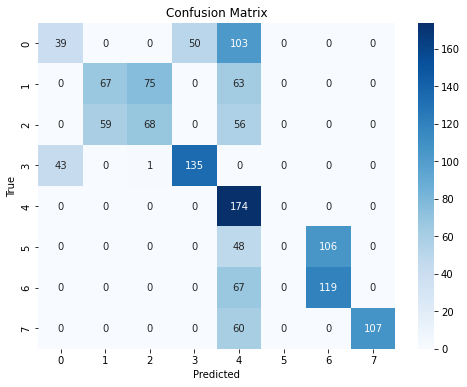

In [40]:
y_pred = cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### P-CNN with all AC Components

In [41]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_all)

X_train, X_test, y_train, y_test = train_test_split(Xall, encoded_labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=8)
y_test_encoded = to_categorical(y_test, num_classes=8)
y_valid_encoded = to_categorical(y_valid, num_classes=8)

X_train = np.array(X_train)
y_train_encoded = np.array(y_train_encoded)
X_valid = np.array(X_valid)
y_valid_encoded = np.array(y_valid_encoded)

def statistical_moments(x):
    min_val = K.min(x, axis=1, keepdims=True)
    max_val = K.max(x, axis=1, keepdims=True)
    mean_val = K.mean(x, axis=1, keepdims=True)
    return K.concatenate([min_val, max_val, mean_val], axis=1)

cnn = tf.keras.Sequential()
cnn.add(layers.Conv1D(8, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Conv1D(16, kernel_size=5, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Conv1D(32, kernel_size=5, activation='relu'))
cnn.add(layers.MaxPooling1D(pool_size=2))
cnn.add(layers.Lambda(statistical_moments))  # Add the statistical moments layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(8, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

cnn.fit(X_train, y_train_encoded, batch_size=128, epochs=500, validation_data=(X_valid, y_valid_encoded))

loss, accuracy = cnn.evaluate(X_test, y_test_encoded)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

/Users/mohitkumar/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/500
36/36 [==============================] - 3s 71ms/step - loss: 7.2689 - accuracy: 0.1131 - val_loss: 3.2413 - val_accuracy: 0.2431
Epoch 2/500
36/36 [==============================] - 3s 79ms/step - loss: 2.4285 - accuracy: 0.2756 - val_loss: 1.8154 - val_accuracy: 0.3359
Epoch 3/500
36/36 [==============================] - 3s 95ms/step - loss: 1.6784 - accuracy: 0.4045 - val_loss: 1.5771 - val_accuracy: 0.4427
Epoch 4/500
36/36 [==============================] - 3s 87ms/step - loss: 1.4981 - accuracy: 0.4418 - val_loss: 1.4512 - val_accuracy: 0.4644
Epoch 5/500
36/36 [==============================] - 3s 83ms/step - loss: 1.3995 - accuracy: 0.4481 - val_loss: 1.3809 - val_accuracy: 0.4688
Epoch 6/500
36/36 [==============================] - 3s 82ms/step - loss: 1.3331 - accuracy: 0.4709 - val_loss: 1.3325 - val_accuracy: 0.4783
Epoch 7/500
36/36 [==============================] - 3s 84ms/step - loss: 1.2945 - accuracy: 0.4698 - val_loss: 1.2934 - val_accuracy: 0.4852
Epoch 

36/36 [==============================] - 3s 76ms/step - loss: 0.8596 - accuracy: 0.5749 - val_loss: 0.9000 - val_accuracy: 0.5425
Epoch 59/500
36/36 [==============================] - 3s 75ms/step - loss: 0.8637 - accuracy: 0.5603 - val_loss: 0.9238 - val_accuracy: 0.5477
Epoch 60/500
36/36 [==============================] - 3s 75ms/step - loss: 0.8610 - accuracy: 0.5725 - val_loss: 0.9030 - val_accuracy: 0.5451
Epoch 61/500
36/36 [==============================] - 3s 74ms/step - loss: 0.8604 - accuracy: 0.5742 - val_loss: 0.9064 - val_accuracy: 0.5460
Epoch 62/500
36/36 [==============================] - 3s 75ms/step - loss: 0.8580 - accuracy: 0.5736 - val_loss: 0.9054 - val_accuracy: 0.5451
Epoch 63/500
36/36 [==============================] - 3s 77ms/step - loss: 0.8608 - accuracy: 0.5751 - val_loss: 0.8964 - val_accuracy: 0.5564
Epoch 64/500
36/36 [==============================] - 3s 78ms/step - loss: 0.8603 - accuracy: 0.5718 - val_loss: 0.8884 - val_accuracy: 0.5703
Epoch 65/500

36/36 [==============================] - 3s 84ms/step - loss: 0.8328 - accuracy: 0.5911 - val_loss: 0.8961 - val_accuracy: 0.5477
Epoch 116/500
36/36 [==============================] - 3s 80ms/step - loss: 0.8363 - accuracy: 0.5909 - val_loss: 0.8994 - val_accuracy: 0.5486
Epoch 117/500
36/36 [==============================] - 3s 82ms/step - loss: 0.8377 - accuracy: 0.5987 - val_loss: 0.9040 - val_accuracy: 0.5512
Epoch 118/500
36/36 [==============================] - 3s 81ms/step - loss: 0.8323 - accuracy: 0.5953 - val_loss: 0.8895 - val_accuracy: 0.5443
Epoch 119/500
36/36 [==============================] - 3s 81ms/step - loss: 0.8308 - accuracy: 0.5994 - val_loss: 0.9162 - val_accuracy: 0.5486
Epoch 120/500
36/36 [==============================] - 3s 84ms/step - loss: 0.8330 - accuracy: 0.5977 - val_loss: 0.8923 - val_accuracy: 0.5434
Epoch 121/500
36/36 [==============================] - 3s 81ms/step - loss: 0.8315 - accuracy: 0.6005 - val_loss: 0.9097 - val_accuracy: 0.5477
Epoch 

Epoch 172/500
36/36 [==============================] - 3s 76ms/step - loss: 0.8147 - accuracy: 0.6174 - val_loss: 0.9139 - val_accuracy: 0.5477
Epoch 173/500
36/36 [==============================] - 3s 78ms/step - loss: 0.8126 - accuracy: 0.6096 - val_loss: 0.9159 - val_accuracy: 0.5443
Epoch 174/500
36/36 [==============================] - 3s 76ms/step - loss: 0.8138 - accuracy: 0.6155 - val_loss: 0.9160 - val_accuracy: 0.5443
Epoch 175/500
36/36 [==============================] - 3s 76ms/step - loss: 0.8091 - accuracy: 0.6209 - val_loss: 0.9313 - val_accuracy: 0.5625
Epoch 176/500
36/36 [==============================] - 3s 80ms/step - loss: 0.8130 - accuracy: 0.6039 - val_loss: 0.9391 - val_accuracy: 0.5451
Epoch 177/500
36/36 [==============================] - 3s 81ms/step - loss: 0.8138 - accuracy: 0.6050 - val_loss: 0.9113 - val_accuracy: 0.5486
Epoch 178/500
36/36 [==============================] - 3s 81ms/step - loss: 0.8104 - accuracy: 0.6165 - val_loss: 0.9227 - val_accuracy:

Epoch 229/500
36/36 [==============================] - 3s 84ms/step - loss: 0.7897 - accuracy: 0.6272 - val_loss: 0.9613 - val_accuracy: 0.5451
Epoch 230/500
36/36 [==============================] - 3s 75ms/step - loss: 0.7841 - accuracy: 0.6265 - val_loss: 0.9510 - val_accuracy: 0.5469
Epoch 231/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7861 - accuracy: 0.6311 - val_loss: 0.9633 - val_accuracy: 0.5391
Epoch 232/500
36/36 [==============================] - 3s 75ms/step - loss: 0.7853 - accuracy: 0.6289 - val_loss: 0.9515 - val_accuracy: 0.5399
Epoch 233/500
36/36 [==============================] - 3s 75ms/step - loss: 0.7813 - accuracy: 0.6265 - val_loss: 0.9671 - val_accuracy: 0.5425
Epoch 234/500
36/36 [==============================] - 3s 74ms/step - loss: 0.7848 - accuracy: 0.6200 - val_loss: 0.9720 - val_accuracy: 0.5443
Epoch 235/500
36/36 [==============================] - 3s 82ms/step - loss: 0.7899 - accuracy: 0.6194 - val_loss: 0.9734 - val_accuracy:

Epoch 286/500
36/36 [==============================] - 3s 76ms/step - loss: 0.7678 - accuracy: 0.6330 - val_loss: 1.0089 - val_accuracy: 0.5451
Epoch 287/500
36/36 [==============================] - 3s 76ms/step - loss: 0.7671 - accuracy: 0.6332 - val_loss: 1.0119 - val_accuracy: 0.5660
Epoch 288/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7693 - accuracy: 0.6317 - val_loss: 1.0124 - val_accuracy: 0.5668
Epoch 289/500
36/36 [==============================] - 3s 86ms/step - loss: 0.7690 - accuracy: 0.6300 - val_loss: 1.0133 - val_accuracy: 0.5417
Epoch 290/500
36/36 [==============================] - 3s 95ms/step - loss: 0.7673 - accuracy: 0.6298 - val_loss: 1.0052 - val_accuracy: 0.5451
Epoch 291/500
36/36 [==============================] - 3s 89ms/step - loss: 0.7658 - accuracy: 0.6326 - val_loss: 1.0043 - val_accuracy: 0.5469
Epoch 292/500
36/36 [==============================] - 3s 80ms/step - loss: 0.7652 - accuracy: 0.6298 - val_loss: 1.0089 - val_accuracy:

Epoch 343/500
36/36 [==============================] - 3s 76ms/step - loss: 0.7560 - accuracy: 0.6359 - val_loss: 1.0574 - val_accuracy: 0.5417
Epoch 344/500
36/36 [==============================] - 3s 76ms/step - loss: 0.7561 - accuracy: 0.6376 - val_loss: 1.0610 - val_accuracy: 0.5625
Epoch 345/500
36/36 [==============================] - 3s 76ms/step - loss: 0.7549 - accuracy: 0.6372 - val_loss: 1.0711 - val_accuracy: 0.5408
Epoch 346/500
36/36 [==============================] - 3s 76ms/step - loss: 0.7523 - accuracy: 0.6317 - val_loss: 1.0721 - val_accuracy: 0.5443
Epoch 347/500
36/36 [==============================] - 3s 77ms/step - loss: 0.7574 - accuracy: 0.6374 - val_loss: 1.0647 - val_accuracy: 0.5625
Epoch 348/500
36/36 [==============================] - 3s 80ms/step - loss: 0.7534 - accuracy: 0.6350 - val_loss: 1.0911 - val_accuracy: 0.5425
Epoch 349/500
36/36 [==============================] - 3s 83ms/step - loss: 0.7572 - accuracy: 0.6382 - val_loss: 1.0976 - val_accuracy:

Epoch 400/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7524 - accuracy: 0.6372 - val_loss: 1.1100 - val_accuracy: 0.5530
Epoch 401/500
36/36 [==============================] - 3s 77ms/step - loss: 0.7521 - accuracy: 0.6313 - val_loss: 1.1293 - val_accuracy: 0.5408
Epoch 402/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7502 - accuracy: 0.6378 - val_loss: 1.1365 - val_accuracy: 0.5451
Epoch 403/500
36/36 [==============================] - 3s 79ms/step - loss: 0.7508 - accuracy: 0.6376 - val_loss: 1.1253 - val_accuracy: 0.5694
Epoch 404/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7486 - accuracy: 0.6413 - val_loss: 1.1346 - val_accuracy: 0.5425
Epoch 405/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7505 - accuracy: 0.6391 - val_loss: 1.1355 - val_accuracy: 0.5495
Epoch 406/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7507 - accuracy: 0.6402 - val_loss: 1.1385 - val_accuracy:

Epoch 457/500
36/36 [==============================] - 3s 77ms/step - loss: 0.7485 - accuracy: 0.6408 - val_loss: 1.2214 - val_accuracy: 0.5512
Epoch 458/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7504 - accuracy: 0.6367 - val_loss: 1.1816 - val_accuracy: 0.5469
Epoch 459/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7452 - accuracy: 0.6391 - val_loss: 1.2134 - val_accuracy: 0.5382
Epoch 460/500
36/36 [==============================] - 3s 79ms/step - loss: 0.7463 - accuracy: 0.6311 - val_loss: 1.1993 - val_accuracy: 0.5356
Epoch 461/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7477 - accuracy: 0.6376 - val_loss: 1.1897 - val_accuracy: 0.5495
Epoch 462/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7477 - accuracy: 0.6359 - val_loss: 1.1838 - val_accuracy: 0.5477
Epoch 463/500
36/36 [==============================] - 3s 78ms/step - loss: 0.7463 - accuracy: 0.6315 - val_loss: 1.1787 - val_accuracy:

45/45 [==============================] - 0s 5ms/step


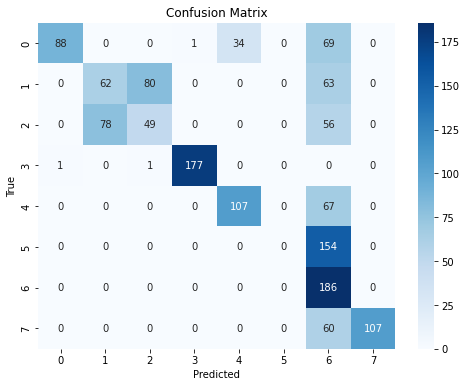

In [42]:
y_pred = cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest with 9 AC components

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_9, y9, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/var/folders/05/xx9dl7rs0d317st9q5sw3vtr0000gn/T/ipykernel_46838/110262095.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Accuracy: 0.375


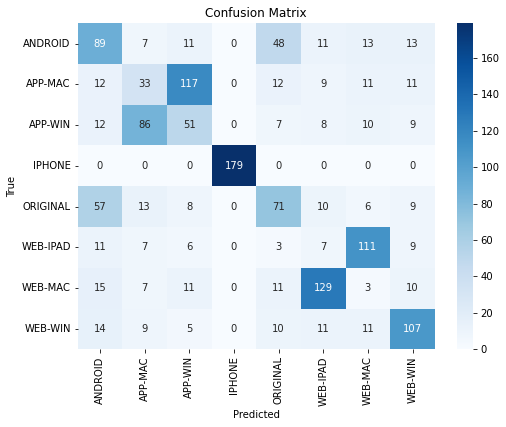

In [44]:
y_pred = rf_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest with all AC components

In [45]:
X_train, X_test, y_train, y_test = train_test_split(Xall, y_all, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/var/folders/05/xx9dl7rs0d317st9q5sw3vtr0000gn/T/ipykernel_46838/897266095.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Accuracy: 0.37430555555555556


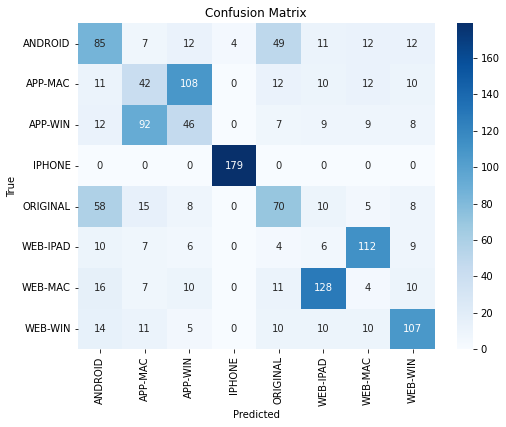

In [46]:
y_pred = rf_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()